## <center> Credit Risk Modelling - IFRS9 and CECL: Developing Scorecards with Machine Learning
#### <br> <center> @by Donald Kpatcha

In [221]:
## Uncomment to install it
#! pip uninstall scorecardpy
#or for the latest version via
#! pip install git+git://github.com/shichenxie/scorecardpy.git


In [219]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import statsmodels.api as sm
import scorecardpy as sc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve, auc, roc_auc_score,  accuracy_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.calibration import calibration_curve
from sklearn.inspection import plot_partial_dependence
from IPython.core.display import HTML
# center plots 
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
from datetime import datetime


### $ \bf \text{Upload and Prepare Data}$

In [207]:
# Import data (data will be provided with this code)
df = pd.read_csv('data/Chap2/chap2oneypdcsv.csv', header=0, sep='"",""|,"|,|",|"""|,""|"",|","',\
                  engine='python').replace('"', '', regex=True).iloc[:, 1:45]

# Default flag definition
df.loc[:, 'default_event'] = df.apply(lambda row: 'Yes' if row['arrears_event'] == 1 \
                                          or row['term_expiry_event'] == 1 \
                                          or row['bankrupt_event'] == 1 else 'No', axis=1)

# Default indicator variable for more convenient use: 0-default, 1-non-default
df.loc[:, 'default_indicator'] = df['default_event'].apply(lambda x: 0 if x == 'No' else 1)

# Displaying the structure of the DataFrame
print(df.info())

# Look at data
df.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25906 entries, 0 to 25905
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             25906 non-null  int64  
 1   vintage_year                   25906 non-null  int64  
 2   monthly_installment            25906 non-null  float64
 3   loan_balance                   25906 non-null  float64
 4   bureau_score                   25473 non-null  float64
 5   num_bankrupt_iva               25473 non-null  float64
 6   time_since_bankrupt            25473 non-null  float64
 7   num_ccj                        25473 non-null  float64
 8   time_since_ccj                 25473 non-null  float64
 9   ccj_amount                     25473 non-null  float64
 10  num_bankrupt                   25473 non-null  float64
 11  num_iva                        25473 non-null  float64
 12  min_months_since_bankrupt      25473 non-null 

,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,...,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m,cc_util,annual_income,emp_length,months_since_recent_cc_delinq,default_event,default_indicator
0,6670001,2005,746.70,131304.44,541.0,0.0,0.0,0.0,0.0,0.0,...,-42.0,0.0,132080.0,542.0,0.4578,76749,3,11,No,0
1,9131199,2006,887.40,115486.51,441.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,116972.0,494.0,0.6299,78451,10,7,No,0
2,4963167,2004,1008.50,128381.73,282.0,0.0,0.0,1.0,36.0,459.0,...,1198.0,2.0,128500.0,290.0,0.6331,31038,3,6,Yes,1
3,3918582,2005,458.23,35482.96,461.0,0.0,0.0,0.0,0.0,0.0,...,-114.0,0.0,36610.0,460.0,0.4990,56663,8,6,No,0
4,5949777,2006,431.20,77086.31,466.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,77518.0,468.0,0.9568,77014,10,3,No,0


##### Note:

'recent_arrears_date', and 'months_since_2mia' columns each contain about 97% of NaN/missing enteries,
Thus the two colomns will be dropped. Also, given that we have suficient amount of data, we will drop 
all rows containing NaNs.

In [208]:

# drop recent_arrears_date', and 'months_since_2mia' columns columns and store in new dataframe
datadf = df.drop(['recent_arrears_date', 'months_since_2mia'], axis=1)

# Filter out missing values by removing rows with missing values 
datadf.dropna(inplace=True)

# Date format for relevant date type columns: "origination_date", "maturity_date"
datadf[["origination_date", "maturity_date"]] = \
                       datadf[["origination_date", "maturity_date"]].apply(pd.to_datetime)

# change dtype for columns
datadf[["months_since_recent_cc_delinq"]] = datadf[["months_since_recent_cc_delinq"]].astype('int')

# Remove outliers
oneypd_tree = datadf.loc[(datadf["origination_date"] <= '2007-08-17')]

# Select a subset of variables
oneypd_tree_sel = oneypd_tree[["default_indicator", "default_event", "bureau_score",
                                    "time_since_bankrupt", "num_ccj", "time_since_ccj",
                                    "ccj_amount", "ltv", "mob", "max_arrears_12m",
                                    "max_arrears_bal_6m", "avg_bal_6m", "annual_income",
                                    "loan_balance", "loan_term", "cc_util", "emp_length",
                                    "months_since_recent_cc_delinq"]]


### $ \bf \text{Split into train and test, and perform feature importance analysis}$

$ \bf a)  \quad  \text{Random Forest Classifier}$

Number of trees: 100
Nunber of variables tried at each split: 4
Out-of-bag estimate of score rate: 0.9611945334908047
Out-of-bag estimate of error rate: 0.03880546650919525


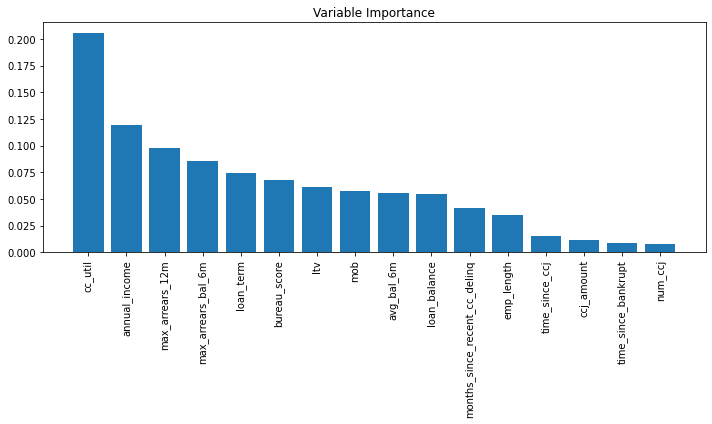

In [209]:

# Create stratified samples: 70% train and 30% test
train, test = train_test_split(oneypd_tree_sel, test_size=0.3, stratify=oneypd_tree_sel['default_event'],\
                               random_state=123)

# Perform random forest analysis
# Fit random forest: creating and fitting a random forest classifier
# The best would be to search for the best paramaters maximizing the acuracy (and perform a cross validation)
# But for now, I will not perform the random grid to search for best hyperparameters just fix n_estimators=100,
# and max_features=4

rf_oneypd = RandomForestClassifier(n_estimators=100, max_features=4, oob_score=True, random_state=123)
rf_oneypd.fit(train.drop(columns=['default_indicator', 'default_event']), train['default_indicator'])

# Displaying random forest details
print("Number of trees:", len(rf_oneypd.estimators_))
print("Nunber of variables tried at each split:", rf_oneypd.max_features)
print("Out-of-bag estimate of score rate:", rf_oneypd.oob_score_)
print("Out-of-bag estimate of error rate:", 1-rf_oneypd.oob_score_)

# Variable importance analysis: plotting variable importance
importances = rf_oneypd.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Variable Importance")
plt.bar(range(train.drop(columns=['default_indicator', 'default_event']).shape[1]), importances[indices],
        align="center")
plt.xticks(range(train.drop(columns=['default_indicator', 'default_event']).shape[1]),\
           train.drop(columns=['default_indicator', 'default_event']).columns[indices], rotation=90)
plt.tight_layout()
plt.show()


#### Note

This score suggests that:

- High Accuracy: The model exhibits high accuracy, correctly classifying approximately 96.12% of 
the instances it encounters. This suggests that the model is generally effective in making predictions 
on unseen data.

- Low Error Rate: With an out-of-bag error rate of around 3.88%, the model makes errors on only a 
small fraction of the instances it encounters during training. This indicates that the model's performance
is quite reliable, with a relatively low likelihood of misclassification.

Overall Performance: The combination of high accuracy and low error rate suggests that the model
is well-fitted to the training data and likely generalizes well to unseen data. However, it's important 
to further evaluate the model's performance on a separate validation or test dataset to confirm its 
effectiveness and generalization capabilities.

In summary, based on these out-of-bag estimates, the model appears to be robust and reliable for making 
predictions, demonstrating strong performance in terms of both accuracy.


$ \bf b)  \quad  \text{Gradient Boosting Regressor}$

Boosting Analysis Summary:
cc_util 0.3554589690881484
max_arrears_12m 0.22718642266222736
annual_income 0.14502113016266743
loan_term 0.09978923764622857
mob 0.047280094253054995
bureau_score 0.03539365064646129
max_arrears_bal_6m 0.023694797585803975
loan_balance 0.01659932576390259
avg_bal_6m 0.01041565112516538
ltv 0.009210520922722204
months_since_recent_cc_delinq 0.007355918545040642
emp_length 0.0061092082686044396
ccj_amount 0.00588029876934121
time_since_ccj 0.005687621420830098
time_since_bankrupt 0.0031118267642722946
num_ccj 0.001805326375529106


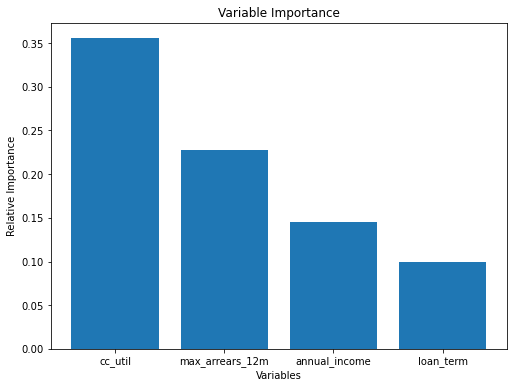

In [220]:

# Here we perform boosting analysis using GradientBoostingRegressor
# I will not perform the random grid to search for best hyperparameters just fix n_estimators=100,
# and  max_depth=4
boost_oneypd = GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=123)
boost_oneypd.fit(train.drop(columns=['default_event', 'default_indicator']), train['default_indicator'])

# Display summary of the boosting analysis
print("Boosting Analysis Summary:")
feature_importance = boost_oneypd.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

# Print variable importance
for idx in sorted_indices:
    print(train.drop(columns=['default_event', 'default_indicator']).columns[idx], feature_importance[idx])

# Plot variable importance for the fmost relevant variables
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.bar(train.drop(columns=['default_event', 'default_indicator']).columns[sorted_indices][:4],
        feature_importance[sorted_indices][:4])
plt.xlabel('Variables')
plt.ylabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


$ \bf \text{Partial dependence}$

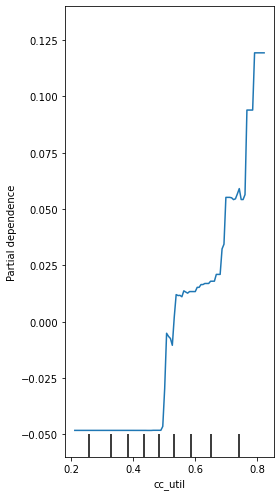

In [211]:
# Uncomment to plot partial dependence plot for the nvar most relevant variables
#nvar = 4
#fig, ax = plt.subplots(1, nvar, figsize=(10, 6))
#for idx in range(nvar):
#    plot_partial_dependence(boost_oneypd, X=train.drop(columns=['default_event', 'default_indicator']),
#                            features=[sorted_indices[idx]], ax=ax[idx])

# Plot partial dependence plot for the top most relevant variable
fig, ax = plt.subplots(figsize=(4, 7))
plot_partial_dependence(boost_oneypd, X=train.drop(columns=['default_event', 'default_indicator']),
                        features=[sorted_indices[0]], ax=ax)
plt.ylim(-0.06, 0.14)

plt.tight_layout()
plt.show()


In [212]:
# Predict on the test data using the trained boosting model
yhat_boost_oneypd = boost_oneypd.predict(test.drop(columns=['default_event', 'default_indicator']))

# Compute mean squared error on the test data
mse_boost_oneypd = mean_squared_error(test['default_indicator'], yhat_boost_oneypd)
print("Mean Squared Error without Shrinkage:", mse_boost_oneypd)

# Inclusion of shrinkage
# Initialize and fit a gradient boosting model with shrinkage
# The best would be to search for the best paramaters maximizing the acuracy (and perform a cross validation)
# But for now, I will not perform the random grid to search for best hyperparameters just fix n_estimators=100,
# learning_rate=0.2, and max_depth=4

boost_oneypd_df = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.2, random_state=1)
boost_oneypd_df.fit(train.drop(columns=['default_event', 'default_indicator']), train['default_indicator'])

# Predict on the test data using the boosted model with shrinkage
yhat_oneypd_df = boost_oneypd_df.predict(test.drop(columns=['default_event', 'default_indicator']))

# Compute mean squared error on the test data with shrinkage
mse_boost_oneypd_df = mean_squared_error(test['default_indicator'], yhat_oneypd_df)
print("Mean Squared Error with Shrinkage (learning rate=0.2):", mse_boost_oneypd_df)


Mean Squared Error without Shrinkage: 0.03000333288142499
Mean Squared Error with Shrinkage (learning rate=0.2): 0.03067419142896672


#### Note:

These metrics from  Gradient Boosting Regressor regularization suggest that:

- Mean Squared Error without Shrinkage: The MSE without shrinkage is 0.03000333288142499. This represents the error incurred by the model when each new tree in the ensemble is added at full strength, without applying any regularization through shrinkage.

- Mean Squared Error with Shrinkage (Learning Rate=0.2): The MSE with shrinkage (learning rate=0.2) is 0.03067419142896672. This indicates the error incurred by the model when a learning rate of 0.2 is applied, meaning that each new tree's contribution to the ensemble is reduced by a factor of 0.2 before being added to the model.

From these values, we can observe that the MSE with shrinkage is slightly higher than the MSE without shrinkage. However, it's essential to note that shrinkage is a regularization technique aimed at improving the model's generalization performance by preventing overfitting. Even though the MSE with shrinkage might be slightly higher, the model's generalization capabilities could potentially be better due to the regularization effect of shrinkage. 


In [213]:

# 1. Create the data set
# Predict probabilities using the random forest model
pred_orig = rf_oneypd.predict_proba(oneypd_tree_sel.drop(columns=['default_event', 'default_indicator']))[:, 1]

# Create a DataFrame with default event and predicted probabilities
rf_db_cal = pd.DataFrame({'def': oneypd_tree_sel['default_indicator'], 'pred': pred_orig})

# 2. Fit calibration function
# Fit a logistic regression model to calibrate the predicted probabilities
pd_model = LogisticRegression()
pd_model.fit(rf_db_cal[['pred']], rf_db_cal['def'])

# Display summary of the logistic regression model
print("Logistic Regression Model Summary:")
print("Intercept:", pd_model.intercept_[0])
print("Coefficient for pred:", pd_model.coef_[0][0])


Logistic Regression Model Summary:
Intercept: -5.3319787537613035
Coefficient for pred: 12.356415964532776


AUC: 0.9399250450076166


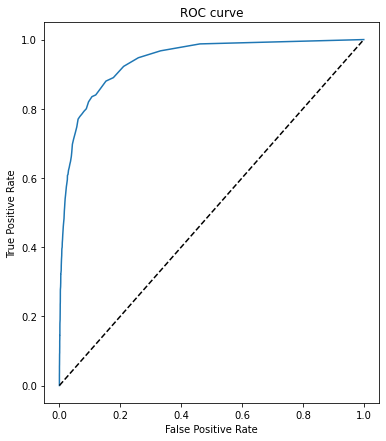

KS: 0.728089599778424
Gini Index: 0.8798500900152333
RMSE: 0.061563869274112386


In [214]:

# Function to create bands based on the predicted probabilities
def create_bands(pred_prob, num_bins=5):
    '''
    Function to create bands based on the predicted probabilities
    '''
    bins = np.linspace(0, 1, num_bins + 1)
    return pd.cut(pred_prob, bins, labels=[f'Bin {i+1}' for i in range(num_bins)], include_lowest=True)

# Predict probabilities using the random forest model
predict_test_orig = rf_oneypd.predict_proba(\
                   test.drop(columns=['default_event', 'default_indicator']))[:, 1]

# Calculate AUC
auc_test = roc_auc_score(test['default_indicator'].values, predict_test_orig)
print("AUC:", auc_test)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(6, 7))
fpr, tpr, _ = roc_curve(test['default_indicator'].values, predict_test_orig)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# KS Analysis
ks_test = np.max(tpr - fpr)
print("KS:", ks_test)

# Gini index
gini_test = 2 * auc_test - 1
print("Gini Index:", gini_test)

# Predict base on model parameters
rf_db_cal['pd'] = pd_model.predict_proba(rf_db_cal[['pred']])[:, 1]

# Create score bands
cuts = [-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf]
labels = ['01 <=0.2', '02 <=0.4', '03 <=0.6', '04 <0.8', '05 >0.8']

# Bin the 'score' variable based on the specified cuts
rf_db_cal['band'] = pd.cut(rf_db_cal['pd'], bins=cuts, labels=labels)

# Could be done manually
#rf_db_cal['band'] = create_bands(rf_db_cal['pd'])

# Compare average actual and fitted PDs
rf_db_cal_plot = rf_db_cal.groupby('band').agg(mean_dr=('def', 'mean'), mean_pd=('pd', 'mean')).round(4).reset_index()

# Compute RMSE
rmse = np.sqrt(np.mean((rf_db_cal_plot['mean_dr'] - rf_db_cal_plot['mean_pd']) ** 2))
print("RMSE:", rmse)


#### Note:

In summary, the model exhibits strong performance across multiple evaluation metrics. With an AUC of 0.9399, it demonstrates high discriminatory power, effectively distinguishing between positive and negative instances. The KS statistic of 0.7281 indicates a significant difference between the true positive and false positive rates, further emphasizing the model's predictive ability. Additionally, the Gini index of 0.8799 highlights the model's effectiveness in ranking instances by their predicted probabilities. Lastly, the low RMSE value of 0.0616 signifies accurate predictions, suggesting that the model's estimates closely align with the observed outcomes. Overall, these metrics collectively indicate that the model is robust and well-performing, making it a reliable tool for predictive tasks.

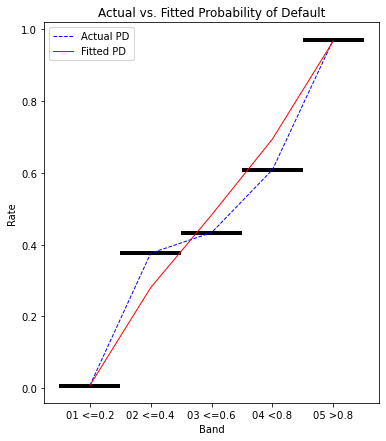

In [217]:
# Plot fitted versus actual data of probability of default
plt.figure(figsize=(6, 7))
plt.plot(rf_db_cal_plot['band'], rf_db_cal_plot['mean_dr'], '--', color='blue', lw=1, label='Actual PD')

for band in range(len(rf_db_cal_plot)):
    plt.hlines(rf_db_cal_plot['mean_dr'][band], band-0.5, band+0.5, color='black', lw=4)

plt.plot(rf_db_cal_plot['band'], rf_db_cal_plot['mean_pd'], '-',  color='red', lw=1, label='Fitted PD')
#plt.xticks(['01 <=0.2', '02 <=0.4', '03 <=0.6', '04 <0.8', '05 >0.8'])
plt.title('Actual vs. Fitted Probability of Default')
plt.xlabel('Band')
plt.ylabel('Rate')
plt.legend()
plt.show()
